In [1]:
from tensorflow.keras.layers import Dense,Flatten,Dropout,MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers,Sequential
import tensorflow as tf
from utils import *
import matplotlib.pyplot as plt
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print("find gpus:",gpus)
# set gpus memory used by growth
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

find gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 载入图片数据
- 读取全部
- 分割训练验证集合

In [3]:
image_shape = (224,224,3)
base_model = tf.keras.applications.VGG19(weights="./pre-trained model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False,input_shape=image_shape)
model = Sequential(base_model.layers[:])
model.add(Flatten())
model.add(Dense(2048,kernel_regularizer=regularizers.l2(0.05), activation='relu'))
model.add(Dense(2048,kernel_regularizer=regularizers.l2(0.05), activation='relu'))
model.add(Dense(3, kernel_regularizer=regularizers.l2(0.05), activation='softmax'))
print(model.summary())

for layer in base_model.layers:
    layer.trainable = False

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [4]:
adam = tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.01, clipnorm=1.)
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.)

# 模型编译
model.compile(optimizer = "adam", # adam, rmsprop, sgd
              loss = "categorical_crossentropy",
              # loss = CC_PEN,
              metrics=["categorical_accuracy"])

In [5]:
his = model.fit(generator("./Train", ["浸润性","良性","原位性"], 3, True),
                steps_per_epoch=70, epochs=100)

Epoch 1/100
70/70 [==============================] - 5s 28ms/step - loss: 50.0547 - categorical_accuracy: 0.4286
Epoch 2/100
70/70 [==============================] - 2s 29ms/step - loss: 6.8618 - categorical_accuracy: 0.5571
Epoch 3/100
70/70 [==============================] - 2s 29ms/step - loss: 3.6874 - categorical_accuracy: 0.5857
Epoch 4/100
70/70 [==============================] - 2s 29ms/step - loss: 2.3596 - categorical_accuracy: 0.6143
Epoch 5/100
70/70 [==============================] - 2s 29ms/step - loss: 1.7931 - categorical_accuracy: 0.5714
Epoch 6/100
70/70 [==============================] - 2s 29ms/step - loss: 1.5841 - categorical_accuracy: 0.5714
Epoch 7/100
70/70 [==============================] - 2s 29ms/step - loss: 1.3108 - categorical_accuracy: 0.5905
Epoch 8/100
70/70 [==============================] - 2s 28ms/step - loss: 1.2337 - categorical_accuracy: 0.5810
Epoch 9/100
70/70 [==============================] - 2s 29ms/step - loss: 1.1910 - categorical_accuracy

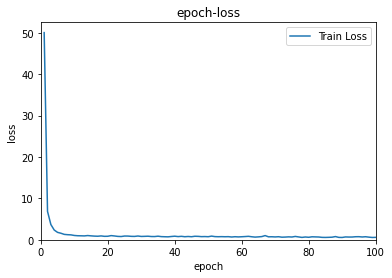

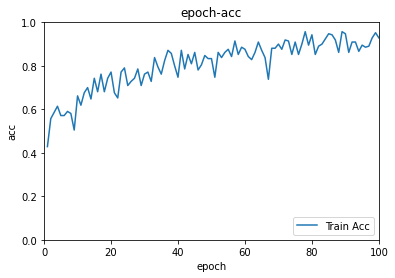

In [6]:
# 可视化
l = np.array(his.history['loss'])
a = np.array(his.history['categorical_accuracy'])
step = np.linspace(1,100,100)
plt.plot(step,l,label="Train Loss")
plt.legend(loc='upper right')
plt.title('epoch-loss')
plt.xlim((0, 100))
plt.gca().set_ylim(bottom=0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./static/vgg19-L4.png', bbox_inches='tight')
plt.show()
plt.plot(step,a,label="Train Acc")
plt.legend(loc='lower right')
plt.title('epoch-acc')
plt.xlim((0, 100))
plt.gca().set_ylim(0,1)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig('./static/vgg19-L4.png', bbox_inches='tight')
plt.show()

In [7]:
from xlwt import *
#需要xlwt库的支持

def export_excel(data,filename='data',path='./'):
    file = Workbook(encoding = 'utf-8')
    #指定file以utf-8的格式打开
    table = file.add_sheet(filename)
    #指定打开的文件名

    ldata = []
    num = [a for a in data]# for循环，取出key值存入num中

    for x in num:
    #for循环将data字典中的键和值分批的保存在ldata中
        t = [x]
        for a in data[x]:
            t.append(a)
        ldata.append(t)

    for i,p in enumerate(ldata):
    #将数据写入文件,i是enumerate()函数返回的序号数
        for j,q in enumerate(p):
            # 横向就是i,j,q;纵向是j,i,q
            table.write(j,i,q)
    file.save('%s.xlsx' % os.path.join(path,filename))

export_excel(his.history,'VGG19-L4',"./static")

In [8]:
# 保存模型
model.save('./model/VGG19-L4.h5')